In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
df = pd.read_csv('/Users/jackcook/Documents/Course notes/Data Sources/2.02. Binary predictors.csv')

## Inspect data

In [3]:
df.head()

,SAT,Admitted,Gender
0,1363,No,Male
1,1792,Yes,Female
2,1954,Yes,Female
3,1653,No,Male
4,1593,No,Male


In [4]:
df_clean = df.copy()
df_clean['Admitted'] = df_clean.Admitted.map({'Yes':1, 'No':0})
df_clean['Gender'] = df_clean.Gender.map({'Female':1, 'Male':0})
df_clean.describe()

,SAT,Admitted,Gender
count,168.000000,168.000000,168.000000
mean,1695.273810,0.559524,0.464286
std,183.019017,0.497928,0.500214
min,1334.000000,0.000000,0.000000
25%,1547.500000,0.000000,0.000000
50%,1691.500000,1.000000,0.000000
75%,1844.500000,1.000000,1.000000
max,2050.000000,1.000000,1.000000


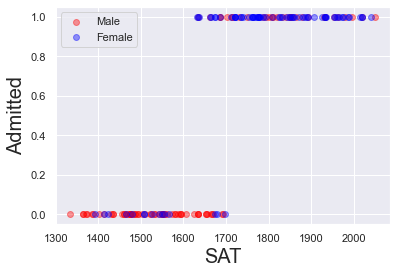

In [5]:
df_male = df_clean[df_clean.Gender == 0]
df_female = df_clean[df_clean.Gender != 0]

plt.scatter(df_male['SAT'],df_male['Admitted'],c='red',alpha=0.4,label='Male')
plt.scatter(df_female['SAT'],df_female['Admitted'],c='blue',alpha=0.4,label='Female')
plt.legend()
plt.xlabel('SAT',fontsize=20)
plt.ylabel('Admitted',fontsize=20)
plt.show()
#cmap='RdYlGn'

### Regression

In [6]:
x1 = df_clean[['Gender','SAT']]
y = df_clean.Admitted

In [7]:
x = sm.add_constant(x1)
reg_log = sm.Logit(y,x) # Logit = logistic
results_log = reg_log.fit() # allows maximum 35 iterations

Optimization terminated successfully.
         Current function value: 0.120117
         Iterations 10


### Summary

In [8]:
results_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Admitted   No. Observations:                  168
Model:                          Logit   Df Residuals:                      165
Method:                           MLE   Df Model:                            2
Date:                Sat, 13 Jun 2020   Pseudo R-squ.:                  0.8249
Time:                        19:32:35   Log-Likelihood:                -20.180
converged:                       True   LL-Null:                       -115.26
Covariance Type:            nonrobust   LLR p-value:                 5.118e-42
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -68.3489     16.454     -4.154      0.000    -100.598     -36.100
Gender         1.9449      0.846      2.299      0.022       0.287       3.603
SAT            0.0406      0.010      4.129      0.000       0.021       0.060
==============================================================================

Possibly complete quasi-separation: A fraction 0.27 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

**MLE:** Maximum likelihood estimation, how likely it is that the model describes realy relationship of variables (model performance).

**Log-likelihood:** What MLE tries to maximise. Almost always negative

**LL-Null:** the log-likelihood of a model that has no dependent variables (ie. if you fitted y to an array of 1's). Compare to log-likelihood!

**LLR p-value:** Measures whether model is statistically different from LL-null (aka the useless model).

**Pseudo R-squared:** McFadden's R-squared, a good value should be 0.2-0.4, only comparable with similar models!


The coefficients can be interpreted as following:
- An increase of 1 in SAT results in a e^0.0406 - 1 (104.14%) higher likelihood of admittance
- Being female increases likelihood of admission by e^1.9449 - 1 (635%)


## Accuracy

In [9]:
# pred_table() returns a table which compares predicted & actual values
cm_df = pd.DataFrame(results_log.pred_table())
cm_df.columns = ['Predicted 0', 'Predicted 1']
cm_df = cm_df.rename(index={0:'Actual 0',1:"Actual 1"})
cm_df

,Predicted 0,Predicted 1
Actual 0,69.0,5.0
Actual 1,4.0,90.0


## Testing

In [10]:
df_test = pd.read_csv('/Users/jackcook/Documents/Course notes/Data Sources/2.03. Test dataset.csv')
df_test.head()

,SAT,Admitted,Gender
0,1323,No,Male
1,1725,Yes,Female
2,1762,Yes,Female
3,1777,Yes,Male
4,1665,No,Male


In [11]:
df_clean_test = df_test.copy()
df_clean_test['Admitted'] = df_clean_test.Admitted.map({'Yes':1, 'No':0})
df_clean_test['Gender'] = df_clean_test.Gender.map({'Female':1, 'Male':0})
df_clean_test.describe()

,SAT,Admitted,Gender
count,19.000000,19.000000,19.000000
mean,1716.157895,0.684211,0.578947
std,189.579729,0.477567,0.507257
min,1323.000000,0.000000,0.000000
25%,1610.500000,0.000000,0.000000
50%,1726.000000,1.000000,1.000000
75%,1842.500000,1.000000,1.000000
max,2039.000000,1.000000,1.000000


In [12]:
test_actual = df_clean_test['Admitted']
test_data = df_clean_test.drop(['Admitted'],axis=1)
test_data = sm.add_constant(test_data)
test_data

,const,SAT,Gender
0,1.0,1323,0
1,1.0,1725,1
2,1.0,1762,1
3,1.0,1777,0
4,1.0,1665,0
5,1.0,1556,1
6,1.0,1731,1
7,1.0,1809,1
8,1.0,1930,1
9,1.0,1708,0


In [13]:
def confusion_matrix(data,actual_values,model):
        
        #Predict values using Logit model
        pred_values = model.predict(data)
        #Specify bins
        bins = np.array([0,0.5,1])
        # Create histograme, where if values are between 0 & 0.5 - then considered as 0,
        # if values are between 0.5 & 1, then considered as 1
        cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
        accuracy = (cm[0,0]+cm[1,1])/cm.sum() # True positives + true negatives over total
        return cm, accuracy

In [14]:
cm, accuracy = confusion_matrix(test_data, test_actual, results_log)
cm, accuracy

(array([[ 0.,  6.],
        [ 0., 13.]]),
 0.6842105263157895)